# Analysis and visualization for main figures

In [2]:
import numpy as np
from scipy.spatial.distance import jensenshannon
import pandas as pd
from tqdm import tqdm
import pickle
import json
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
import collections
import os
import re
import joblib

In [2]:
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import umap

/Users/yoshi/opt/miniforge3/envs/bertopic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /Users/yoshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from transformers import AutoTokenizer, AutoModel, BertTokenizer
from bertopic import BERTopic
import torch

In [5]:
plt.rcParams['font.family'] = 'Arial'

In [3]:
path = './'

# 1. Data loading

In [5]:
df=pd.read_csv(path+'Polymer2.csv')
df

,Unnamed: 0,Reference Type,Year,Title,Author,Journal,Abstract,Times Cited,ISSN
0,0,Journal Article,1990,"Arylidene Polymers .5. Synthesis, Characteriza...","Abdalla, M. A.",Journal of Macromolecular Science-Chemistry,"A new [(2-oxo-1,3-cyclopentanediylidene)bis(me...",NaN,0022-233x
1,0,Journal Article,1990,"Apatite Coating on Ceramics, Metals and Polyme...","Abe, Y., Kokubo, T. and Yamamuro, T.",Journal of Materials Science-Materials in Medi...,A novel method of apatite coating is presented...,14.0,0957-4530
2,0,Journal Article,1990,New Aspects of Polymer Drugs,"Akashi, M. and Takemoto, K.",Advances in Polymer Science,This article reviews results on the studies of...,9.0,0065-3195
3,0,Journal Article,1990,Polymer Gels in Uniaxial Deformation,"Alexander, S. and Rabin, Y.",Journal of Physics-Condensed Matter,The recent analysis of osmotic pressure in a s...,1.0,0953-8984
4,0,Journal Article,1990,Glass-Transition in Polymers - Freezing of Rot...,"Allegra, G., Bignotti, F., Gargani, L. and Co...",Macromolecules,A nonlattice model based on space-filling crit...,NaN,0024-9297
...,...,...,...,...,...,...,...,...,...
275733,0,Journal Article,2024,Corona: An effective polarization strategy of ...,"Yi, J., Ye, Z. W., Zhang, S. X., Song, Y. H.,...",Applied Energy,Piezoelectric nanogenerators (PENGs) are mushr...,NaN,0306-2619
275734,0,Journal Article,2024,Electrospray deposited plant-based polymer nan...,"Yontar, A. K. and Çevik, S.",Progress in Organic Coatings,The present study was designed to apply the El...,NaN,0300-9440
275735,0,Journal Article,2024,Shape- and polymer-considered simulation to un...,"Zeng, Y. C., Wang, H., Liang, D. F., Yuan, W....",Journal of Hazardous Materials,Environmental microplastics (MPs) constitute v...,NaN,0304-3894
275736,0,Journal Article,2024,"High-efficient Ag(I) ion binding, Ag(0) nanopa...","Zhang, J., Pu, N., Li, M. L., Sang, W. H., He...",Separation and Purification Technology,Interest in functional silver has rapidly grow...,NaN,1383-5866


In [8]:
df['Title']

0         Arylidene Polymers .5. Synthesis, Characteriza...
1         Apatite Coating on Ceramics, Metals and Polyme...
2                              New Aspects of Polymer Drugs
3                      Polymer Gels in Uniaxial Deformation
4         Glass-Transition in Polymers - Freezing of Rot...
                                ...                        
275733    Corona: An effective polarization strategy of ...
275734    Electrospray deposited plant-based polymer nan...
275735    Shape- and polymer-considered simulation to un...
275736    High-efficient Ag(I) ion binding, Ag(0) nanopa...
275737    An interpenetrating polymer networks based on ...
Name: Title, Length: 275738, dtype: object

# 2. Model loading

In [9]:
model_name=["BERT", "SciBERT", "MatSciBERT"]

In [10]:
model_name=["BERT", "SciBERT", "MatSciBERT"]
topics_title, topics_abstract=[], []
for name in model_name:
    with open(path+"models/title/topics_"+name+"_title.pkl", "rb") as f:
        topics_title.append(pickle.load(f))
    with open(path+"models/abstract/topics_"+name+"_abstract.pkl", "rb") as f:
        topics_abstract.append(pickle.load(f))

In [11]:
df_sum_title=pd.concat([df['Year'], pd.DataFrame(topics_title, index=model_name).T], axis=1)
df_sum_title

,Year,BERT,SciBERT,MatSciBERT
0,1990,-1,28,7
1,1990,-1,-1,-1
2,1990,-1,810,-1
3,1990,31,-1,946
4,1990,-1,-1,-1
...,...,...,...,...
275733,2024,-1,-1,-1
275734,2024,-1,-1,-1
275735,2024,-1,-1,27
275736,2024,-1,-1,2


In [12]:
df_sum_abstract=pd.concat([df['Year'], pd.DataFrame(topics_abstract, index=model_name).T], axis=1)
df_sum_abstract

,Year,BERT,SciBERT,MatSciBERT
0,1990,-1,49,-1
1,1990,-1,364,369
2,1990,-1,-1,-1
3,1990,-1,-1,-1
4,1990,-1,-1,-1
...,...,...,...,...
275733,2024,-1,27,-1
275734,2024,-1,-1,-1
275735,2024,5,-1,-1
275736,2024,-1,-1,-1


# Figure 1

In [21]:
if not os.path.exists(path+"models/title/umap_"+name+"_title.joblib"):
    for name in model_name:
        embeddings=np.load(path+"models/title/embeddings_"+name+"_title.npy")
        umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
        umap_model.fit(embeddings)
        joblib.dump(umap_model, path+"models/title/umap_"+name+"_title.joblib")
        print ("title: ", name)

if not os.path.exists(path+"models/abstract/umap_"+name+"_abstract.joblib"):
    for name in model_name:
        embeddings=np.load(path+"models/abstract/embeddings_"+name+"_abstract.npy")
        umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
        umap_model.fit(embeddings)
        joblib.dump(umap_model, path+"models/abstract/umap_"+name+"_abstract.joblib")
        print ("abstract: ", name)

title:  BERT
title:  SciBERT
title:  MatSciBERT
abstract:  BERT
abstract:  SciBERT
abstract:  MatSciBERT


# Figure 1a-c

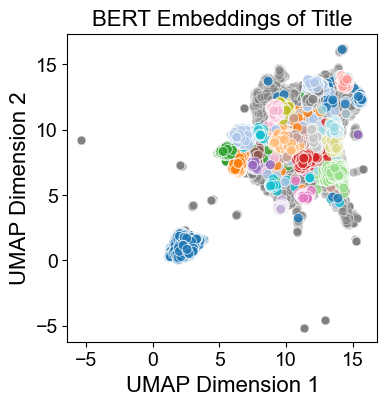

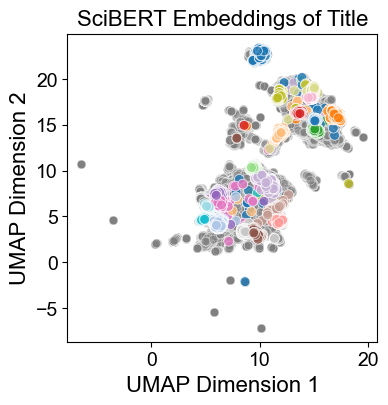

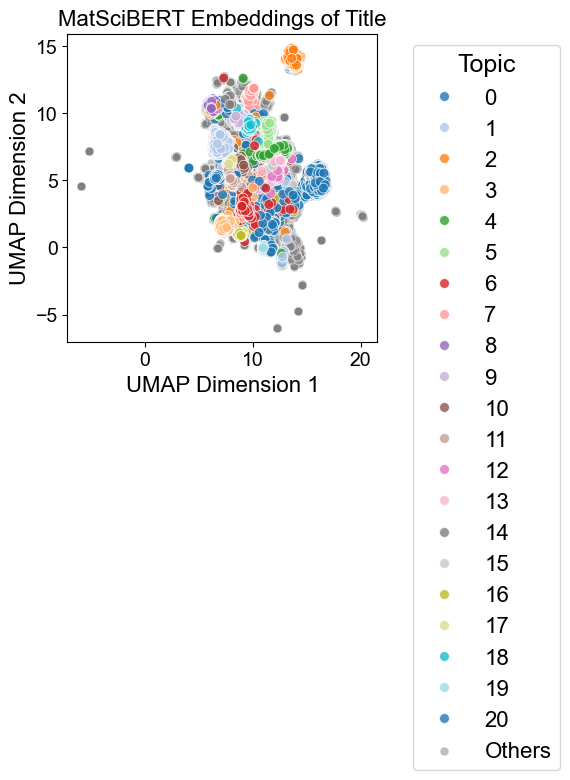

In [32]:
df_sum=df_sum_title.copy()

for i, name in enumerate(model_name): 
    embeddings=np.load(path+"models/title/embeddings_"+name+"_title.npy")
    umap_model = joblib.load(path+"models/title/umap_"+name+"_title.joblib")
    embedding_2d = umap_model.transform(embeddings)

    df_umap = pd.DataFrame(embedding_2d, columns=["x", "y"])
    df_umap2=df_umap[(df_sum[name]!=-1)&(df_sum[name]<21)]
    df_umap2["Topic"]=df_sum[name][(df_sum[name]!=-1)&(df_sum[name]<21)]

    plt.figure(figsize=(4, 4))
    sns.scatterplot(data=df_umap2, x="x", y="y", hue="Topic", palette="tab20", s=50, alpha=0.8)
    sns.scatterplot(data=df_umap, x='x', y='y', color='gray', alpha=0.5, s=40, label='Others', zorder=-10)

    plt.title(name+" Embeddings of Title", fontsize=16)
    plt.xlabel("UMAP Dimension 1", fontsize=16)
    plt.ylabel("UMAP Dimension 2", fontsize=16)
    if i==2:
        plt.legend(title="Topic", bbox_to_anchor=(1.08, 1), loc="upper left", ncol=1, fontsize=16, title_fontsize=18)
    else:
        plt.legend().remove()
    plt.tick_params(labelsize=14)

    #plt.tight_layout()
    plt.show()

# Figure 1d-f

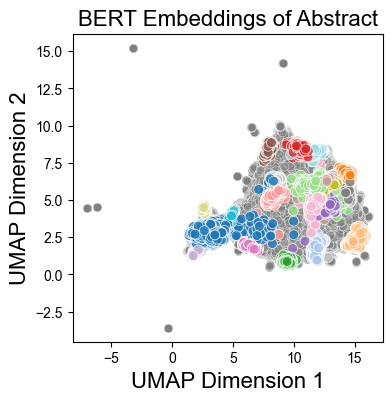

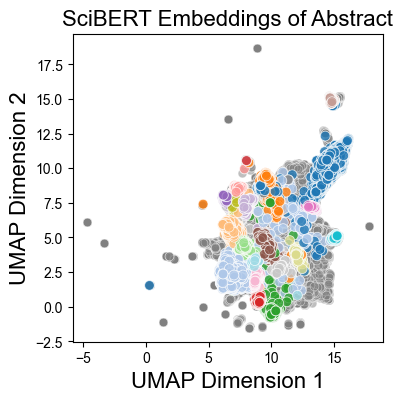

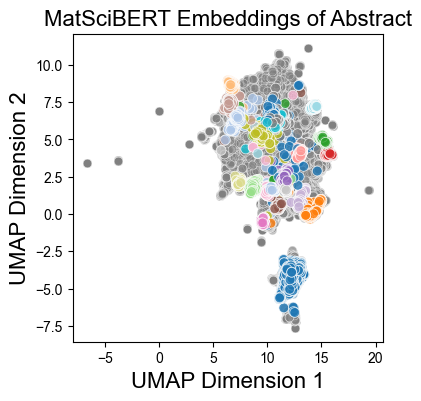

In [31]:
df_sum=df_sum_abstract.copy()

for i, name in enumerate(model_name): 
    embeddings=np.load(path+"models/abstract/embeddings_"+name+"_abstract.npy")
    umap_model = joblib.load(path+"models/abstract/umap_"+name+"_abstract.joblib")
    embedding_2d = umap_model.transform(embeddings)

    df_umap = pd.DataFrame(embedding_2d, columns=["x", "y"])
    df_umap2=df_umap[(df_sum[name]!=-1)&(df_sum[name]<21)]
    df_umap2["Topic"]=df_sum[name][(df_sum[name]!=-1)&(df_sum[name]<21)]

    plt.figure(figsize=(4, 4))
    sns.scatterplot(data=df_umap2, x="x", y="y", hue="Topic", palette="tab20", s=50, alpha=0.8)
    sns.scatterplot(data=df_umap, x='x', y='y', color='gray', alpha=0.5, s=40, label='Others', zorder=-10)

    plt.title(name+" Embeddings of Abstract", fontsize=16)
    plt.xlabel("UMAP Dimension 1", fontsize=16)
    plt.ylabel("UMAP Dimension 2", fontsize=16)
    plt.legend().remove()
    plt.gcf().patch.set_alpha(0.0) 

    #plt.tight_layout()
    plt.show()

# Figure 2

# Figure 2a

In [204]:
topic_counts_title = []
separability_scores_title = []

for name in model_name:
    model=BERTopic.load(path+"models/title/model_"+name+"_title")
    centroids = model.c_tf_idf_.toarray()  
    
    num_topics = len(model.get_topic_info())

    distances = pairwise_distances(centroids, metric="cosine")
    upper_triangle = distances[np.triu_indices_from(distances, k=1)]
    separability = np.mean(upper_triangle)

    topic_counts_title.append(num_topics)
    separability_scores_title.append(separability)

In [205]:
topic_counts_abstract = []
separability_scores_abstract = []

for name in model_name:
    model=BERTopic.load(path+"models/abstract/model_"+name+"_abstract")
    centroids = model.c_tf_idf_.toarray()  
    
    num_topics = len(model.get_topic_info())

    distances = pairwise_distances(centroids, metric="cosine")
    upper_triangle = distances[np.triu_indices_from(distances, k=1)]
    separability = np.mean(upper_triangle)

    topic_counts_abstract.append(num_topics)
    separability_scores_abstract.append(separability)

In [206]:
separability_scores_abstract

[np.float64(0.9476716986067234),
 np.float64(0.9560710812699587),
 np.float64(0.9593113308936614)]

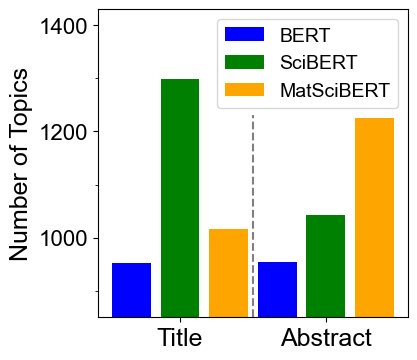

In [226]:
plt.figure(figsize=(4, 4))
plt.bar(np.arange(0,3), topic_counts_title, color=['blue', 'green', 'orange'], label=model_name)
plt.bar(np.arange(3,6), topic_counts_abstract, color=['blue', 'green', 'orange'])
plt.vlines(2.5, 850, 1230, linestyle="dashed", color="gray")
plt.ylabel('Number of Topics', fontsize=18)
plt.xticks(ticks=[1,4], labels=['Title','Abstract'], fontsize=18)
plt.yticks(ticks=[1000,1200,1400], fontsize=16)
plt.ylim(850, 1430)
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(100))
plt.legend(loc='upper right', fontsize=14)

# Figure 2b

In [142]:
def compute_vocab_coverage(words, tokenizer):
    total = len(words)
    covered = sum(1 for w in words if w in tokenizer.vocab)
    return covered / total if total > 0 else 0

In [151]:
docs = df["Title"].str.lower().tolist()

models = {
    "BERT": "bert-base-uncased",
    "SciBERT": "allenai/scibert_scivocab_uncased",
    "MatSciBERT": "m3rg-iitd/matscibert"
}

if not os.path.exists(path + "models/title/cover_title.csv"):
    cover_sum=[]
    for name, model in models.items():
        tokenizer = BertTokenizer.from_pretrained(model)

        all_words = set(word for doc in docs for word in word_tokenize(doc))
        vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
        X = vectorizer.fit_transform(docs)
        tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))
        top_words = sorted(tfidf_scores.items(), key=lambda x: -x[1])[:100]
        important_words = set(word for word, _ in top_words)

        all_word_coverage = compute_vocab_coverage(all_words, tokenizer)
        important_word_coverage = compute_vocab_coverage(important_words, tokenizer)
        cover_sum.append([name, all_word_coverage, important_word_coverage])
    
    df_cover=pd.DataFrame(cover_sum, columns=["Model", "Cover_all", "Cover_important_word"])
    df_cover.to_csv(path + "models/title/cover_title.csv", index=False)
    
df_cover_title=pd.read_csv(path + "models/title/cover_title.csv")
df_cover_title

,Model,Cover_all,Cover_important_word
0,BERT,0.076915,0.87
1,SciBERT,0.089277,0.93
2,MatSciBERT,0.089277,0.93


In [152]:
docs = df["Abstract"].str.lower().tolist()

models = {
    "BERT": "bert-base-uncased",
    "SciBERT": "allenai/scibert_scivocab_uncased",
    "MatSciBERT": "m3rg-iitd/matscibert"
}

if not os.path.exists(path + "models/abstract/cover_abstract.csv"):
    cover_sum=[]
    for name, model in models.items():
        tokenizer = BertTokenizer.from_pretrained(model)

        all_words = set(word for doc in docs for word in word_tokenize(doc))
        vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
        X = vectorizer.fit_transform(docs)
        tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))
        top_words = sorted(tfidf_scores.items(), key=lambda x: -x[1])[:100]
        important_words = set(word for word, _ in top_words)

        all_word_coverage = compute_vocab_coverage(all_words, tokenizer)
        important_word_coverage = compute_vocab_coverage(important_words, tokenizer)
        cover_sum.append([name, all_word_coverage, important_word_coverage])
    
    df_cover=pd.DataFrame(cover_sum, columns=["Model", "Cover_all", "Cover_important_word"])
    df_cover.to_csv(path + "models/abstract/cover_abstract.csv", index=False)
    
df_cover_abstract=pd.read_csv(path + "models/abstract/cover_abstract.csv")
df_cover_abstract

,Model,Cover_all,Cover_important_word
0,BERT,0.025368,0.96
1,SciBERT,0.024539,1.00
2,MatSciBERT,0.024539,1.00


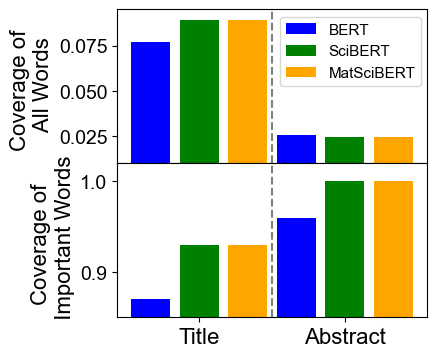

In [195]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(4, 4), gridspec_kw={'hspace': 0})  

ax1.bar(np.arange(0,3), df_cover_title["Cover_all"], color=['blue', 'green', 'orange'], label=model_name)
ax1.bar(np.arange(3,6), df_cover_abstract["Cover_all"], color=['blue', 'green', 'orange'])
ax1.axvline(x=2.5, color='gray', linestyle='--', linewidth=1.5)
ax1.set_ylabel('Coverage of \n All Words', fontsize=16)
ax1.set_ylim(0.01,0.095)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xticks([])  
ax1.legend(fontsize=11, bbox_to_anchor=(0.5,1))

ax2.bar(np.arange(0,3), df_cover_title["Cover_important_word"], color=['blue', 'green', 'orange'], label=model_name)
ax2.bar(np.arange(3,6), df_cover_abstract["Cover_important_word"], color=['blue', 'green', 'orange'], label=model_name)
ax2.axvline(x=2.5, color='gray', linestyle='--', linewidth=1.5)
ax2.set_ylabel('Coverage of \n Important Words', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xticks(ticks=[1,4], labels=['Title','Abstract'], fontsize=16)
ax2.set_ylim(0.85,1.02)

#plt.tight_layout()
plt.show()

# Figure 2c

In [67]:
if not os.path.exists(path+"models/title/SilhouetteScore_title.csv"):
    df_sum=df_sum_title.copy()
    sl_list=[]
    for i,name in enumerate(model_name): 
        embeddings = np.load(path+"models/title/embeddings_"+name+"_title.npy")
        umap_model = joblib.load(path+"models/title/umap_"+name+"_title.joblib")
        embedding_2d = umap_model.transform(embeddings)
        sl_list.append([silhouette_score(embeddings[df_sum[name]!=-1], df_sum[name][df_sum[name]!=-1]),
                silhouette_score(embeddings[(df_sum[name]!=-1)&(df_sum[name]<20)], df_sum[name][(df_sum[name]!=-1)&(df_sum[name]<20)]),
                silhouette_score(embedding_2d[df_sum[name]!=-1], df_sum[name][df_sum[name]!=-1]),
                silhouette_score(embedding_2d[(df_sum[name]!=-1)&(df_sum[name]<20)], df_sum[name][(df_sum[name]!=-1)&(df_sum[name]<20)])])
        print (sl_list[i])
    pd.DataFrame(sl_list).to_csv(path+"models/title/SilhouetteScore_title.csv")

df_SilhouetteScore_title=pd.read_csv(path+"models/title/SilhouetteScore_title.csv", usecols=range(1, 5))
df_SilhouetteScore_title.columns=["emb_all", "emb_20", "umap_all", "umap_20"]
df_SilhouetteScore_title.index=["BERT", "SciBERT", "MatBERT"]
df_SilhouetteScore_title

[-0.019756730645895004, 0.08325071632862091, -0.026416916400194168, 0.5149556398391724]
[0.004043745808303356, 0.1156628355383873, -0.03580855950713158, 0.7876314520835876]
[-0.01948273740708828, 0.035761620849370956, -0.019179649651050568, 0.6655685901641846]


,emb_all,emb_20,umap_all,umap_20
BERT,-0.019757,0.083251,-0.026417,0.514956
SciBERT,0.004044,0.115663,-0.035809,0.787631
MatBERT,-0.019483,0.035762,-0.019180,0.665569


In [361]:
if not os.path.exists(path+"models/abstract/SilhouetteScore_abstract.csv"):
    df_sum=df_sum_abstract.copy()
    sl_list=[]
    for i,name in enumerate(model_name): 
        embeddings = np.load(path+"models/abstract/embeddings_"+name+"_abstract.npy")
        umap_model = joblib.load(path+"models/abstract/umap_"+name+"_abstract.joblib")
        embedding_2d = umap_model.transform(embeddings)
        sl_list.append([silhouette_score(embeddings[df_sum[name]!=-1], df_sum[name][df_sum[name]!=-1]),
                silhouette_score(embeddings[(df_sum[name]!=-1)&(df_sum[name]<20)], df_sum[name][(df_sum[name]!=-1)&(df_sum[name]<20)]),
                silhouette_score(embedding_2d[df_sum[name]!=-1], df_sum[name][df_sum[name]!=-1]),
                silhouette_score(embedding_2d[(df_sum[name]!=-1)&(df_sum[name]<20)], df_sum[name][(df_sum[name]!=-1)&(df_sum[name]<20)])])
        print (sl_list[i])
    pd.DataFrame(sl_list).to_csv(path+"models/abstract/SilhouetteScore_abstract.csv")

df_SilhouetteScore_abstract=pd.read_csv(path+"models/abstract/SilhouetteScore_abstract.csv", usecols=range(1, 5))
df_SilhouetteScore_abstract.columns=["emb_all", "emb_20", "umap_all", "umap_20"]
df_SilhouetteScore_abstract.index=["BERT", "SciBERT", "MatBERT"]
df_SilhouetteScore_abstract

[-0.02819899469614029, 0.07970376312732697, -0.09957185387611389, 0.5674986243247986]
[-0.04768965020775795, 0.06413741409778595, -0.130740225315094, 0.520843505859375]
[-0.021268444135785103, 0.11138807982206345, -0.1267797350883484, 0.6231781840324402]


,emb_all,emb_20,umap_all,umap_20
BERT,-0.028199,0.079704,-0.099572,0.567499
SciBERT,-0.047690,0.064137,-0.130740,0.520844
MatBERT,-0.021268,0.111388,-0.126780,0.623178


In [82]:
df_SilhouetteScore_title[["emb_20", "umap_20"]]

,emb_20,umap_20
BERT,0.083251,0.514956
SciBERT,0.115663,0.787631
MatBERT,0.035762,0.665569


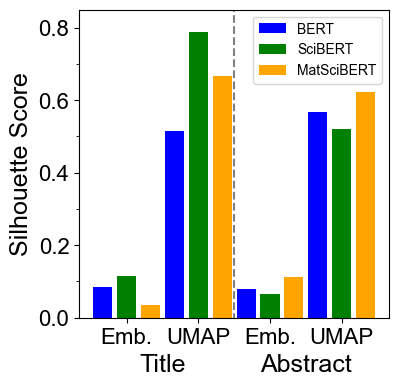

In [374]:
plt.figure(figsize=(4, 4))
plt.bar(np.arange(0,3), df_SilhouetteScore_title["emb_20"], color=['blue', 'green', 'orange'], label=model_name)
plt.bar(np.arange(3,6), df_SilhouetteScore_title["umap_20"], color=['blue', 'green', 'orange'])
plt.bar(np.arange(6,9), df_SilhouetteScore_abstract["emb_20"], color=['blue', 'green', 'orange'])
plt.bar(np.arange(9,12), df_SilhouetteScore_abstract["umap_20"], color=['blue', 'green', 'orange'])
plt.vlines(5.5, -0.01, 0.85, linestyle="dashed", color="gray")
plt.ylabel('Silhouette Score', fontsize=18)
plt.xticks(ticks=[1,4,7,10], labels=['Emb.','UMAP','Emb.','UMAP'], fontsize=16)
plt.yticks(ticks=[0.0,0.2,0.4,0.6,0.8], fontsize=16)
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.text(2.5, -0.15, 'Title', ha='center', fontsize=18)
plt.text(8.5, -0.15, 'Abstract', ha='center', fontsize=18)
plt.ylim(0.0, 0.85)
plt.legend()

# Figure 2d

In [198]:
df_coherence_title=pd.read_csv(path + "models/title/coherence_title.csv")
df_coherence_title

,Model,Coherence
0,BERT,0.440298
1,SciBERT,0.460600
2,MatSciBERT,0.478713


In [199]:
df_coherence_abstract=pd.read_csv(path + "models/abstract/coherence_abstract.csv")
df_coherence_abstract

,Model,Coherence
0,BERT,0.456040
1,SciBERT,0.533331
2,MatSciBERT,0.548818


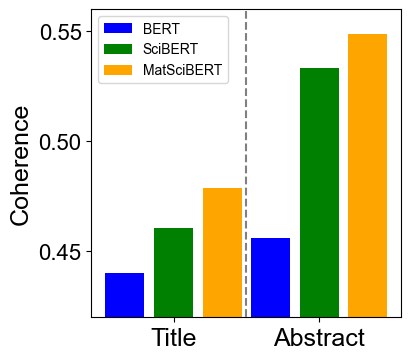

In [203]:
plt.figure(figsize=(4, 4))
plt.bar(np.arange(0,3), df_coherence_title["Coherence"], color=['blue', 'green', 'orange'], label=model_name)
plt.bar(np.arange(3,6), df_coherence_abstract["Coherence"], color=['blue', 'green', 'orange'])
plt.vlines(2.5, -0.18, 0.8, linestyle="dashed", color="gray")
plt.ylabel('Coherence', fontsize=18)
plt.xticks(ticks=[1,4], labels=['Title','Abstract'], fontsize=18)
plt.yticks(ticks=[0.45,0.5,0.55], fontsize=16)
plt.ylim(0.42, 0.56)
plt.legend(loc='upper left')

# Figure 3

In [14]:
def html_like_to_latex(text):
    text = re.sub(r'sub(.*?)sub', r'$_{\1}$', text)
    text = re.sub(r'sup(.*?)sup', r'$^{\1}$', text)
    return text

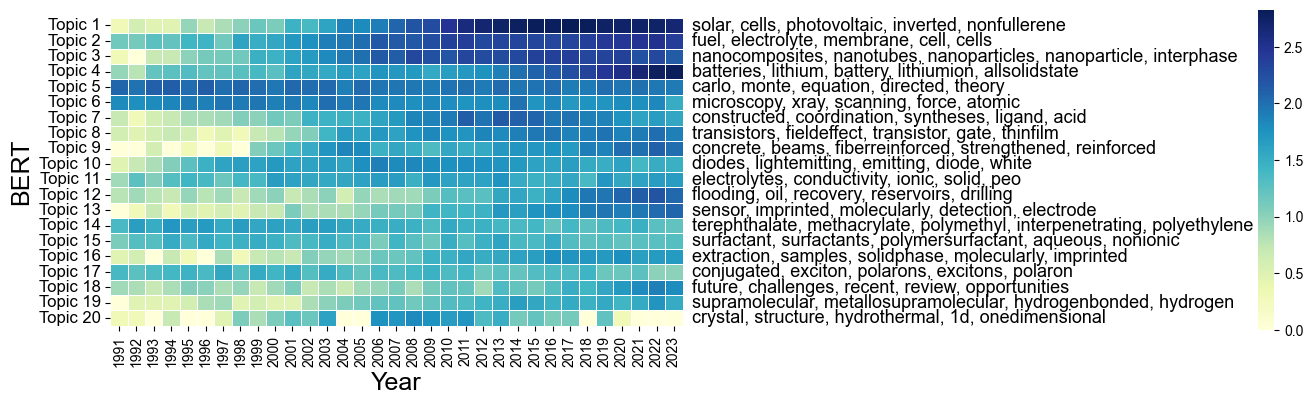

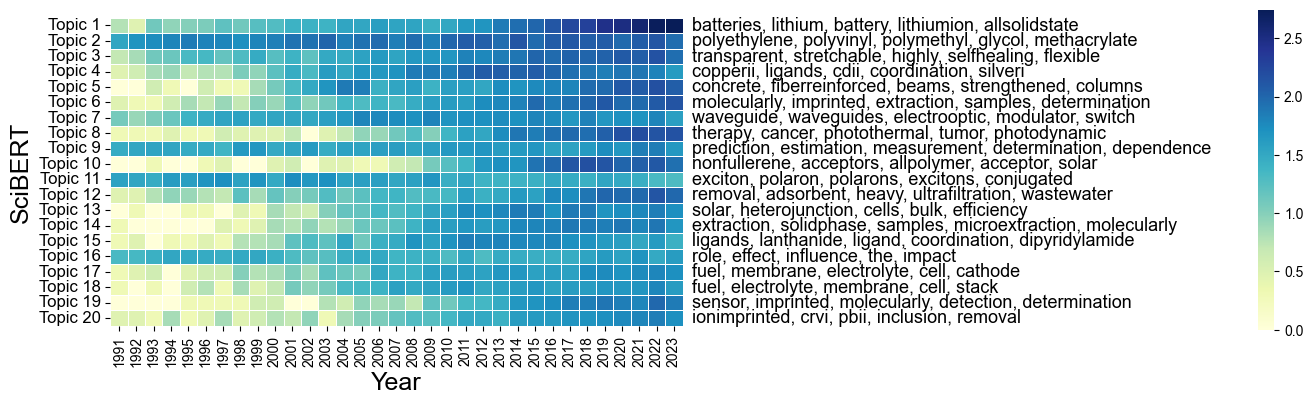

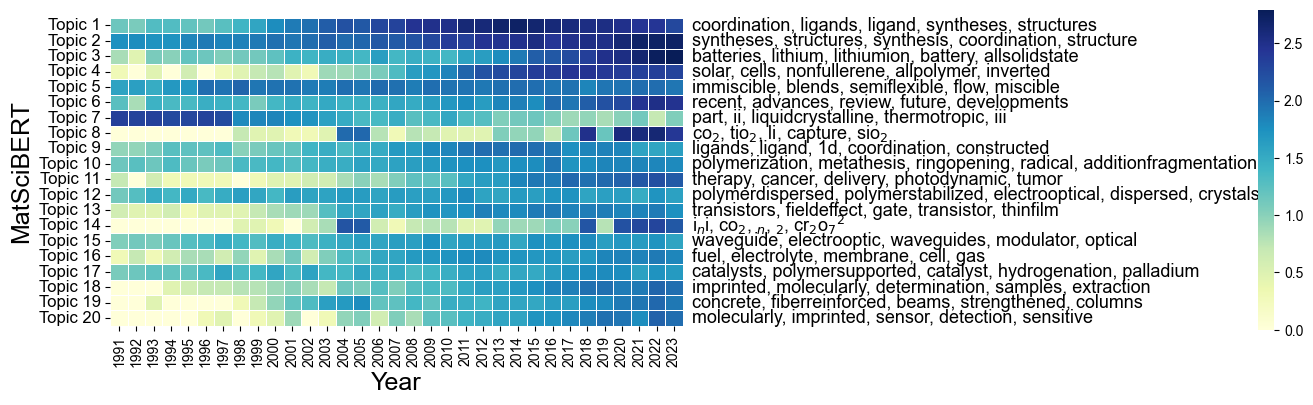

In [28]:
No_topics=20
row_labels = [f"Topic {i+1}" for i in range(No_topics)]

model_name=["BERT", "SciBERT", "MatSciBERT"]
for name in model_name:
    topic_year_counts = df_sum_title[df_sum_title[name] != -1].groupby(["Year", name]).size().unstack(fill_value=0)
    topic_year_counts = topic_year_counts.sort_index(axis=1)
    model=BERTopic.load(path+"models/title/model_"+name+"_title")
    
    fig = plt.figure(figsize=(8, 4))
    gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1.5, 1], wspace=-0.7)

    ax_label = fig.add_subplot(gs[1])
    ax_label.set_xlim(0, 1)
    ax_label.set_ylim(0, No_topics)

    for i in range(No_topics):
        if (i==18)&(name=="BERT"):
            keywords_raw = model.get_topic_info()['Representation'][i+2][:4]
            keywords_latex = [html_like_to_latex(kw) for kw in keywords_raw]
            keywords_str = ", ".join(keywords_latex)
            ax_label.text(0.9, No_topics - i - 0.5,
                          keywords_str,
                          va='center', ha='left', fontsize=13)
        else:
            keywords_raw = model.get_topic_info()['Representation'][i+2][:5]
            keywords_latex = [html_like_to_latex(kw) for kw in keywords_raw]
            keywords_str = ", ".join(keywords_latex)
            ax_label.text(0.9, No_topics - i - 0.5,
                          keywords_str,
                          va='center', ha='left', fontsize=13)
    
    ax_label.axis('off')  

    ax_heatmap = fig.add_subplot(gs[0])
    sns.heatmap(np.log10(topic_year_counts.T[1:No_topics+1]+1),
                cmap="YlGnBu", linewidths=0.5,
                ax=ax_heatmap,
                cbar=True, yticklabels=row_labels,
                cbar_ax=fig.add_axes([1.56, 0.1, 0.02, 0.8]),
                ) 
    ax_heatmap.set_xlim(1,34)
    ax_heatmap.set_yticklabels(ax_heatmap.get_yticklabels(), fontsize=12)
    ax_heatmap.set_ylabel(name, fontsize=18)
    ax_heatmap.set_xlabel("Year", fontsize=18)
    
    plt.tight_layout()
    plt.show()

# Figure 4

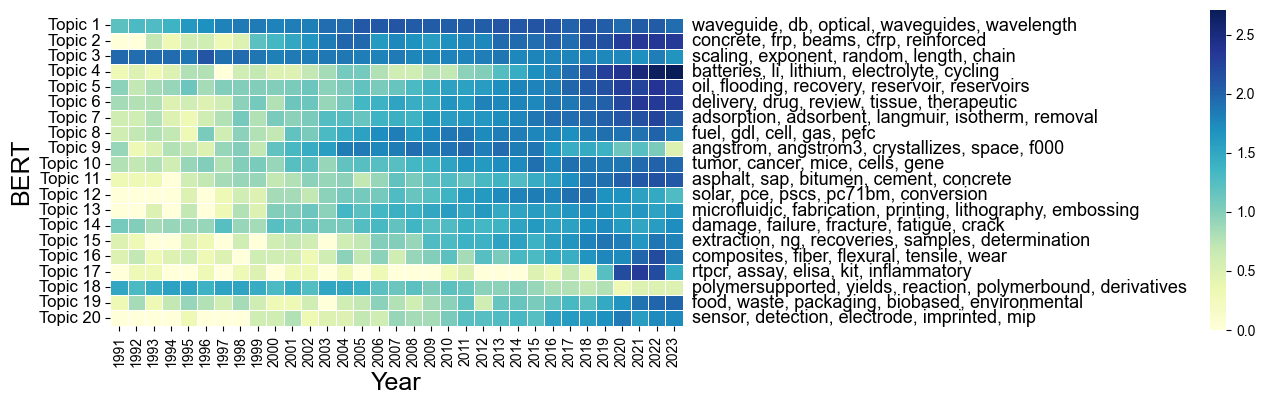

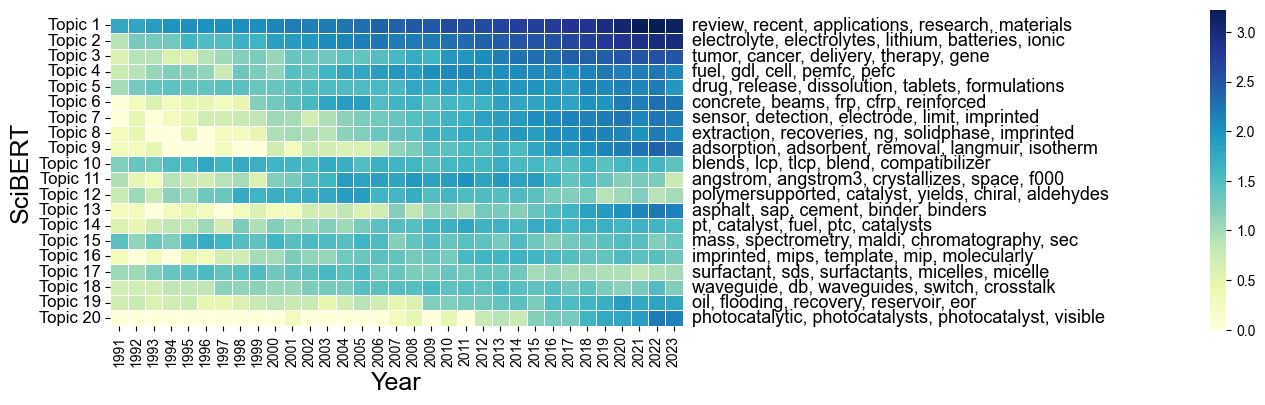

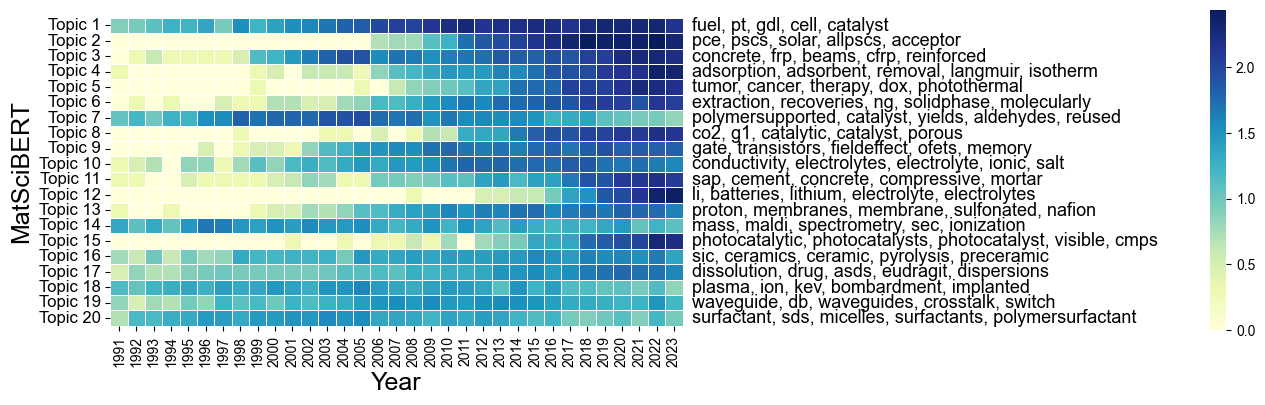

In [33]:
No_topics=20
row_labels = [f"Topic {i+1}" for i in range(No_topics)]

model_name=["BERT", "SciBERT", "MatSciBERT"]

for name in model_name:
    topic_year_counts = df_sum_abstract[df_sum_abstract[name] != -1].groupby(["Year", name]).size().unstack(fill_value=0)
    topic_year_counts = topic_year_counts.sort_index(axis=1)
    model=BERTopic.load(path+"models/abstract/model_"+name+"_abstract")
    
    fig = plt.figure(figsize=(8, 4))
    gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1.5, 1], wspace=-0.7)

    ax_label = fig.add_subplot(gs[1])
    ax_label.set_xlim(0, 1)
    ax_label.set_ylim(0, No_topics)

    for i in range(No_topics):
        if (i==19)&(name=="SciBERT"):
            keywords_raw = model.get_topic_info()['Representation'][i+2][:4]
            keywords_latex = [html_like_to_latex(kw) for kw in keywords_raw]
            keywords_str = ", ".join(keywords_latex)
            ax_label.text(0.9, No_topics - i - 0.5,
                          keywords_str,
                          va='center', ha='left', fontsize=13)
        else:
            keywords_raw = model.get_topic_info()['Representation'][i+2][:5]
            keywords_latex = [html_like_to_latex(kw) for kw in keywords_raw]
            keywords_str = ", ".join(keywords_latex)

            ax_label.text(0.9, No_topics - i - 0.5,
                          keywords_str,
                          va='center', ha='left', fontsize=13)
    
    ax_label.axis('off')  

    ax_heatmap = fig.add_subplot(gs[0])
    sns.heatmap(np.log10(topic_year_counts.T[1:No_topics+1]+1),
                cmap="YlGnBu", linewidths=0.5,
                ax=ax_heatmap,
                cbar=True, yticklabels=row_labels,
                cbar_ax=fig.add_axes([1.5, 0.1, 0.02, 0.8]),
                ) #ax=fig.add_axes([0.1, 0.1, 0.65, 0.8])
    ax_heatmap.set_xlim(1,34)
    ax_heatmap.set_yticklabels(ax_heatmap.get_yticklabels(), fontsize=12)
    ax_heatmap.set_ylabel(name, fontsize=18)
    ax_heatmap.set_xlabel("Year", fontsize=18)
    
    plt.tight_layout()
    plt.show()